In [1]:
import pandas as pd
import numpy as np
import calendar as cal
import datetime
import matplotlib.pyplot as plt

## Questions (suggestions)
 - what were the features of the bond?
 - why the bond was issued?
 - how much was authorized and how much was sold?
 - at what price was the bond originally sold and what was the price history on the secondary market?
 - when was the bond redeemed?

## Data format notes
 - PDF Readme on the dataframe's github [here](https://github.com/jepayne/US-Federal-Debt-Public/blob/master/Industrial-Suite/Documentation/ReadMe_Pub_20180910.pdf)
 - The order in which the categories are listed is not necessarily the same; some are switched to make the list read more logically

### BondList
 - Import id is not used
 - Category L* describes the category in level L*
 - Category L* ID is the numeric ID of the above
 - Issue IDs are the numeric ID of a bond within its category
 - L* ID is the bond's ID within level L* (therefore, L1 ID is the unique id for each bond because it is the highest category, so it is the index)
 - Very few of the Authorizing Act Date entries are actually in the raw data, they may need imputing from the Authorizing Act string - for now, if you want an "issuance date" of the security use the "First Issue Date" column

In [2]:
Bondh5 = pd.HDFStore("data/BondDF.h5", mode="r")
BondList = Bondh5["BondList"]
BondQuant = Bondh5["BondQuant"]
BondPrice = Bondh5["BondPrice"]
Bondh5.close()

In [3]:
# Helper functions

def get_cf_as_string(row):
  """
  Takes a row from the BondList frame and returns the a string indicating the month which the bond
  is scheduled.
  """
  
  for i in range(1, 13):
    if row[f"CF{str(i).zfill(2)}"] > 0: return cal.month_name[i]
  if row["Ambiguous"] > 0: return "Ambiguous"
  return "N/A"

def is_nan(value):
  """
  Utility to check if a value is nan
  """
  str_value = str(value)
  if str_value == "nan" or str_value == "NaT": return True


## Liberty & Victory Loans

 - [This concise article](https://www.federalreservehistory.org/essays/liberty-bonds#footnote1) gives a summary of the bonds
 - Bonds are conveniently classified under the level three category "Liberty Loan"
 - These bonds were used to fund World War I
 - The below cell isolates and prints information about the liberty loans from the BondList dataframe
 - Note: These are all par bonds, meaning their original price is equal to their face value.

In [4]:
BondList.sort_values(by=["First Issue Date"], ascending=True, inplace=True)
liberty_loans = BondList.loc[(BondList['Category L3'] == "Liberty Loan")]
BondList.iloc[:, 0]

def summarize_bond(bond_row):
  noi = bond_row["Treasury's Name Of Issue"]
  print(f"Bond #{bond_row['Issue L1 ID']}: {noi}{', issued ' + str(bond_row['First Issue Date']) if not is_nan(bond_row['First Issue Date']) else ''}")
  if is_nan(bond_row["Term Of Loan"]):
    print("   No further information")
    return bond_row
  print(f"   Term: {bond_row['Term Of Loan']}, Redeemable: {bond_row['Redeemable After Date']}, Payable: {bond_row['Payable Date']}")
  print(f"   Coupon: {bond_row['Coupon Rate']}, Frequency: {bond_row['Coupons Per Year']}/year, Scheduled Month: {get_cf_as_string(bond_row)}")
  print(f"   Is callable: {bond_row['Callable'] == 1.0}, Coin: {'Yes/Unspecified' if bond_row['Coin'] > 0 else 'No'}")
  print("---------------------------------------------------")
  return bond_row

liberty_loans.apply(summarize_bond, axis = 1)
print("Done") #Here so the cell output does not include the dataframe snippet

Bond #162: 1st Liberty Loan of 1917 (3.5%), issued 1917-06-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 3.5, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #166: 2nd Liberty Loan of 1917 (4%), issued 1917-10-31 00:00:00
   Term: 25 years, Redeemable: 1927-11-15 00:00:00, Payable: 1942-11-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: May
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #168: 3rd Liberty Loan, issued 1918-05-31 00:00:00
   Term: 10 years, Redeemable: NaT, Payable: 1928-09-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: March
   Is callable: False, Coin: Yes/Unspecified
---------------------------------------------------
Bond #169: 4th Liberty Loan, issued 1918-09-30 00:00:00
   Term: 20 years, Redeemable: 1933-10-15 00:00:00, Pa

## 1st Liberty Loan of 1917:
Note: these specific loan describing cells aren't put before each loan yet; have not figured out how to insert cells within outputs yet. Also the resources say it was dated on June 15 but thta doesn't make sense as that is before the date first issued.

This loan was the first bond used to fund World War I. It also featured the option to convert it so that it would have a higher coupon rate. Thus, it was converted to having a coupon rate of 4% once and 4.25% twice in 1918. This loan had 4 million subscribers, and offered 2 billon dollars while 3.035 billion dollars were subscribed, but only 2 billion dollars were accepted. An average of 759 dollars were subscribed. 

## 2nd Liberty Loan
This loan was the second bond used to fund World War I. Much like the 1st bond, it had a convertable option. However, unlike the 1st loan, it could only be converted one time, and was converted to having a coupon rate of 4.25% once in 1918. This loan had 9.4 Million subscribers, and offered 3 billion dollars while 4.618 billion dollars was subscribed, but only 3.809 billion dollars were accepted. An average of 491 dollars were subscribed.

## 3rd Liberty Loan
This loan was the third loan used to fund World War I. Unlike the first two loans, it had a convertable option. However, unlike the 1st loan, it could only be converted one time, and was converted to having a coupon rate of 4.25% once in 1918. This loan had 9.4 Million subscribers, and offered 3 billion dollars while 4.618 billion dollars was subscribed, but only 3.809 billion dollars were accepted. An average of 491 dollars were subscribed.

In [5]:
# Now let's analyze what's present in BondQuant
# Notice that in the output of this cell, the Category L1 ID for each bond is 2.
# According to the data Readme, Category L1 ID being 2 corresponds to an Interest Bearing time series
liberty_loans

,Import ID,Category L1,Category L2,Category L3,Category L1 ID,Category L2 ID,Category L3 ID,Issue L1 ID,Issue L2 ID,Issue L3 ID,...,CF10,CF11,CF12,Ambiguous,Coin,Callable,Price Sold,Authorized Amount,Limit On Issued,Marginal Increase In Total Debt Authorized
L1 ID,,,,,,,,,,,,,,,,,,,,,
20162,30045,Interest Bearing,Marketable,Liberty Loan,2,2,14,162,162,1,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN
20166,30049,Interest Bearing,Marketable,Liberty Loan,2,2,14,166,166,5,...,0.0,1.0,0.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20168,30051,Interest Bearing,Marketable,Liberty Loan,2,2,14,168,168,7,...,0.0,0.0,0.0,NaN,1.0,0.0,1.0,NaN,NaN,NaN
20169,30052,Interest Bearing,Marketable,Liberty Loan,2,2,14,169,169,8,...,1.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20165,30048,Interest Bearing,Marketable,Liberty Loan,2,2,14,165,165,4,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20167,30050,Interest Bearing,Marketable,Liberty Loan,2,2,14,167,167,6,...,0.0,1.0,0.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20163,30046,Interest Bearing,Marketable,Liberty Loan,2,2,14,163,163,2,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20164,30047,Interest Bearing,Marketable,Liberty Loan,2,2,14,164,164,3,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
20170,30053,Interest Bearing,Marketable,Liberty Loan,2,2,14,170,170,9,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN


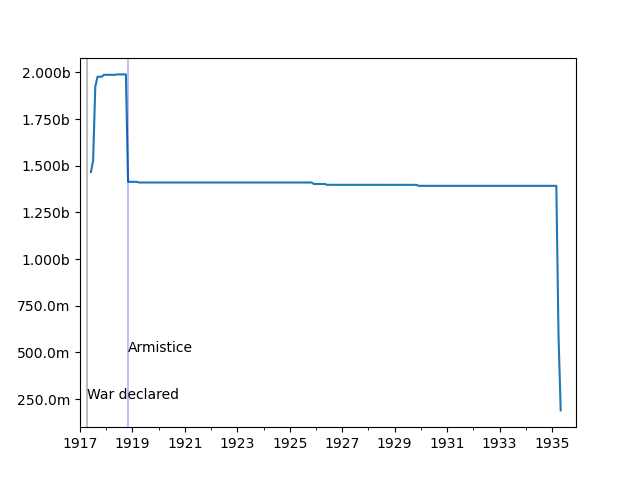

In [6]:
%matplotlib widget
# For example, let's see the first liberty bond in liberty_loans
# Right now, BondQuant is date by column (which is a multiindex)
# It makes more sense (in my mind) if they were switched, so do that now
pd.options.display.float_format = '${:,.0f}'.format

def big_money_format(x, pos):
    strx = str(x)
    if x >= 1e9:
        return f"{strx[0]}.{strx[1:4]}b"
    if x >= 1e8:
        return f"{strx[:3]}.{strx[3]}m"

BondQuant_Transposed = BondQuant.transpose()
first_liberty_series = BondQuant_Transposed.loc[(20162, 'Public Holdings')]
first_liberty_series = first_liberty_series[first_liberty_series.notna()]
ax = first_liberty_series.plot(kind="line")
ax.yaxis.set_major_formatter(big_money_format)
ax.set_xlim(left=pd.Timestamp("1917-1-1"), right=pd.Timestamp("1935-12-31"))

join_ts = pd.Timestamp("1917-4-4")
armistice_ts = pd.Timestamp("1918-11-11")

ax.axvline(join_ts, color="black", alpha=0.25)
ax.annotate("War declared", (join_ts, 2.5e8))

ax.axvline(armistice_ts, color="blue", alpha=0.25)
ax.annotate("Armistice", (armistice_ts, 5e8))

plt.show()

#ax.plot(first_liberty_series.index.to_list()[17])

Here, it is shown that in 1917, the quantity outstanding was at 1,466,335,094, before increasing to nearly 2,000,000,000 and staying around that price before decreasing to around 1,400,000,000 in 1919, staying at around that amount before suddenly decreasing to around 189,928,800. 
The increase at the beginning can be attributed to many liberty bonds being sold at that time to finance WWI. As this resulted in more citizens and households deciding to own financial assets, the decrease soon after this in late 1919 can be attributed to the increase in discount rates used to curb the increase of bond prices, resulting in depreciation of bond prices. By 1935, most of the debt had already been paid back. 


In [7]:
#Here's a quick utility function to get a breakdown of the bond in the bondquant dataset
category_ids = [None, "Pre 1790 Domestic Debt", "Interest Bearing", "Non-interest bearing", "Other", "Asset"]

def get_ts_basic_info_formatted(l1_id, series_name):
    if series_name not in BondQuant_Transposed.loc[l1_id].index: return "N/C"
    series = BondQuant_Transposed.loc[(l1_id, series_name)]
    series = series[series.notna()]
    if len(series) < 1: return "N/A"
    return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"

def bond_quant_breakdown(l1_id):
    #first get the L1 ID level
    level = BondList.loc[l1_id, "Category L1 ID"]
    print(f"Kind: {category_ids[level]}")
    if level == 2:
        print(f"Total Outstanding: {get_ts_basic_info_formatted(l1_id, 'Total Outstanding')}")
        print(f"    Active: {get_ts_basic_info_formatted(l1_id, 'Active Outstanding')}")
        print(f"        Public: {get_ts_basic_info_formatted(l1_id, 'Public Holdings')}")
        print(f"            Coupon: {get_ts_basic_info_formatted(l1_id, 'Coupon')}")
        print(f"            Registered: {get_ts_basic_info_formatted(l1_id, 'Registered')}")
        print(f"        Intra gov: {get_ts_basic_info_formatted(l1_id, 'Intra Government Holdings')}")
        print(f"    Matured: {get_ts_basic_info_formatted(l1_id, 'Matured Outstanding')}")
        print(f"    Called: {get_ts_basic_info_formatted(l1_id, 'Called Outstanding')}")

bond_quant_breakdown(20162)

Kind: Interest Bearing
Total Outstanding: Starting at $1,466,335,094, ending at $189,928,800
    Active: Starting at $1,466,335,094, ending at $189,928,800
        Public: Starting at $1,466,335,094, ending at $189,928,800
            Coupon: Starting at $1,155,779,600, ending at $1,151,418,250
            Registered: Starting at $257,788,300, ending at $262,148,400
        Intra gov: N/A
    Matured: N/A
    Called: N/C


/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_41064/2111161399.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"


In [8]:
# Now let's see what every liberty bond looks like
# yk what would be cool actually? An animated pie chart that shows the distribution of total outstanding over time
# let's do that

first_liberty_series = BondQuant_Transposed.loc[20162]
first_liberty_series = first_liberty_series[first_liberty_series.notna()]
ax = first_liberty_series.plot(kind="pie")
#ax.plot(first_liberty_series.index.to_list()[17])
plt.show()

ValueError: pie requires either y column or 'subplots=True'

In [ ]:
bond_ids = [20162]

fig, ax = plt.subplots()
size = 0.3

series_names = [["Active Outstanding", "Matured Outstanding", "Called Outstanding"], []]

for id in bond_ids:
    series = BondQuant_Transposed.loc[id]
    
    ax.pie(, radius=1,
           wedgeprops=dict(width=size, edgecolor='w'))

    ax.pie(, radius=1-size,
           wedgeprops=dict(width=size, edgecolor='w'))

,1776-12-31,1777-01-31,1777-02-28,1777-03-31,1777-04-30,1777-05-31,1777-06-30,1777-07-31,1777-08-31,1777-09-30,...,1959-09-30,1959-10-31,1959-11-30,1959-12-31,1960-01-31,1960-02-29,1960-03-31,1960-04-30,1960-05-31,1960-06-30
Series,,,,,,,,,,,,,,,,,,,,,
Active Outstanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coupon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intra Government Holdings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Matured Outstanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Public Holdings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Outstanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
